# Object Detection Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [11]:
# !wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

nohup eva_server >> eva.log 2>&1 &
('03-17-2023 00:23:03 INFO  [catalog_manager:catalog_manager.py:_bootstrap_catalog:0076] Bootstrapping catalog\n', '03-17-2023 00:23:03 INFO  [timer:timer.py:log_elapsed_time:0045] Query Compile Time: 0.4414 sec\n', '03-17-2023 00:23:03 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF FastRCNNObjectDetector already exists, nothing added.\n')
('03-17-2023 00:23:03 INFO  [timer:timer.py:log_elapsed_time:0045] Query Compile Time: 0.0013 sec\n', '03-17-2023 00:23:03 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF Array_Count already exists, nothing added.\n', '03-17-2023 00:23:03 INFO  [timer:timer.py:log_elapsed_time:0045] Query Compile Time: 0.0007 sec\n')
('03-17-2023 00:23:03 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF Timestamp already exists, nothing added.\n', '03-17-2023 00:23:03 INFO  [timer:timer.py:log_elapsed_time:0045] Query Compile Time: 0.0009 sec\n', '03-17-2023 00:23:03 WARNING[crea

### Download the Videos

In [12]:
# Getting the video files
!wget -nc https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1 -O ua_detrac.mp4
# Getting the Yolo object detector
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/yolo_object_detector.py

File 'ua_detrac.mp4' already there; not retrieving.
File 'yolo_object_detector.py' already there; not retrieving.



### Load the surveillance videos for analysis

##### We use regular expression to load all the videos into the table

In [13]:
cursor.execute('DROP TABLE ObjectDetectionVideos')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD VIDEO "ua_detrac.mp4" INTO ObjectDetectionVideos;')
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.FAIL
@batch: 
 None
@error: Table: ObjectDetectionVideos does not exist
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 0.09539325535297394


### Visualize Video

In [8]:
from IPython.display import Video
Video("ua_detrac.mp4", embed=True)

### Register YOLO Object Detector an an User-Defined Function (UDF) in EVA 

In [31]:
cursor.execute("""CREATE UDF IF NOT EXISTS YoloV5
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
                scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'yolo_object_detector.py';
      """)

response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                            0
0  UDF YoloV5 already exists, nothing added.
@query_time: 0.01712656207382679


### Run Object Detector on the video

In [32]:
cursor.execute("""SELECT id, Annotate(data, YoloV5(data))
                  FROM ObjectDetectionVideos 
                  WHERE id < 20""")
response = cursor.fetch_all()
dataframe = response.batch.frames


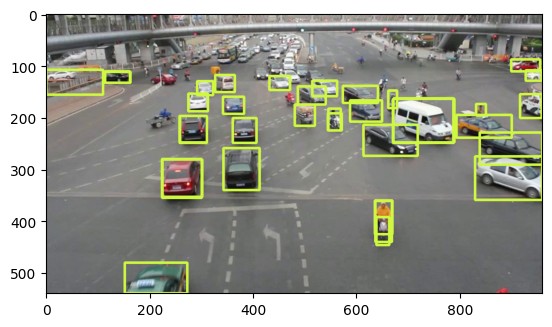

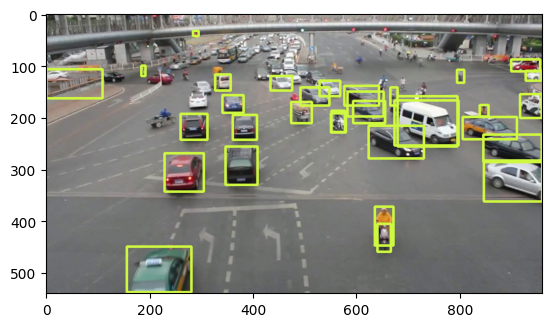

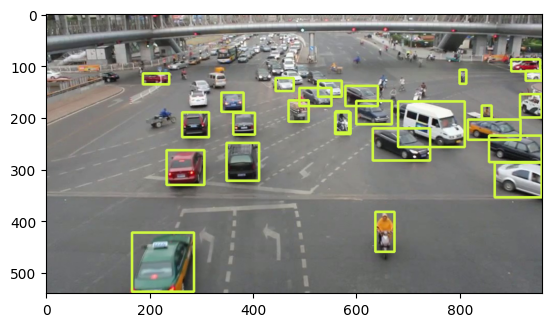

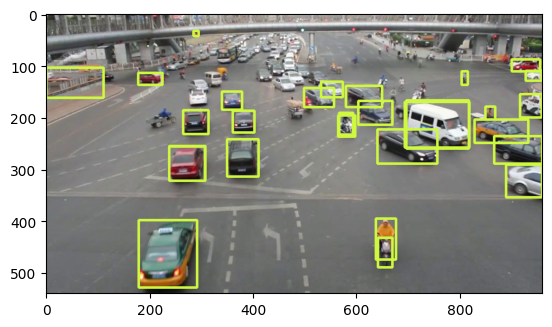

In [33]:
import cv2
from matplotlib import pyplot as plt

vcap = cv2.VideoCapture('ua_detrac.mp4')
width = int(vcap.get(3))
height = int(vcap.get(4))
fps = vcap.get(5)
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
video=cv2.VideoWriter('output.mp4', fourcc, fps, (width,height))

df = dataframe

dfLst = df.values.tolist()
for i in range(0,20):
    frame = dfLst[i][1]
    if i % 5 == 0: 
        plt.imshow(frame)
        plt.show()
    video.write(frame)

video.release()
vcap.release()

### Visualizing output of the Object Detector on the video

In [10]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        df = detections
        df = df[['yolov5.bboxes', 'yolov5.labels']][df.index == frame_id]
        if df.size:
            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[0][0], dfLst[0][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                # object bbox
                frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
                # object label
                cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness) 
                # frame label
                cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
            video.write(frame)

            # Stop after twenty frames (id < 20 in previous query)
            if frame_id == 20:
                break

            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()

        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

In [29]:
from ipywidgets import Video, Image
input_path = 'ua_detrac.mp4'
output_path = 'video.mp4'

# dataframe = response.as_df()
# annotate_video(dataframe, input_path, output_path)
Video.from_file(output_path)

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\x0c\x01N...')

### Dropping an User-Defined Function (UDF)

In [12]:
cursor.execute("DROP UDF YoloV5;")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                  0
0  UDF YoloV5 successfully dropped
@query_time: 0.1606277789996966
